In [97]:
from lsst.daf.butler import Butler
import numpy as np
import os
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from astroML.crossmatch import crossmatch_angular
import pandas as pd

In [2]:
REPO = "/epyc/ssd/users/kmrakovc/DATA/rc2_subset/SMALL_HSC/"
OUTPUT_COLL = "u/kmrakovc/single_frame_injection_01"
# Instantiate a butler.
butler = Butler(REPO)

In [103]:
injection_catalog_ids = list(butler.registry.queryDatasets("injected_postISRCCD_catalog", collections=OUTPUT_COLL, instrument='HSC'))
source_catalog_ids = list(butler.registry.queryDatasets("injected_src", collections=OUTPUT_COLL, instrument='HSC'))
matched_trails = pd.DataFrame()
original_trails = pd.DataFrame()
for i in range(len(injection_catalog_ids)):
    injection_catalog= butler.get("injected_postISRCCD_catalog", dataId=injection_catalog_ids[0].dataId, collections=OUTPUT_COLL,)
    source_catalog= butler.get("injected_src", dataId=source_catalog_ids[0].dataId, collections=OUTPUT_COLL,)
    
    icp = injection_catalog.to_pandas()
    scp =source_catalog.asAstropy().to_pandas()

    col = list (scp.columns)
    col.remove('coord_ra'), col.remove('coord_dec')
    col = ['coord_ra', 'coord_dec'] + col
    scp = scp[col]
    scp = scp[scp['deblend_nChild'] == 0]
    scp[['coord_ra', 'coord_dec']] = scp[['coord_ra', 'coord_dec']]*180/np.pi
    
    col = list (icp.columns)
    col.remove('ra'), col.remove('dec')
    col = ['ra', 'dec'] + col
    icp = icp[col]
    
    dist, ind = crossmatch_angular(icp[['ra', 'dec']].values, scp[['coord_ra', 'coord_dec']].values, 2. / 3600)
    match = ~np.isinf(dist)
    matched_trails = pd.concat([matched_trails, icp[match]], ignore_index=True)
    original_trails = pd.concat([original_trails, icp], ignore_index=True)
    print ("\r",i+1,"/", len(source_catalog_ids), end="")

 234 / 234

In [104]:
original_trails

,ra,dec,injection_id,injection_flag,injection_draw_size,source_type,trail_length,mag,beta,visit
0,150.164151,2.162934,0,0,64,Trail,29,20.649543,78.266903,322
1,150.205028,2.097555,2,0,28,Trail,4,20.105215,10.641037,322
2,150.120673,2.178979,4,0,46,Trail,18,23.206311,0.169721,322
3,150.136346,2.152246,5,0,72,Trail,33,21.208137,67.336033,322
4,150.234997,2.153748,6,0,88,Trail,41,22.074169,37.944085,322
...,...,...,...,...,...,...,...,...,...,...
4909,150.252715,2.122112,18,0,46,Trail,18,25.670411,72.683535,322
4910,150.216211,2.099343,19,0,64,Trail,29,22.050606,70.331152,322
4911,150.105219,2.103564,1,0,132,Trail,64,23.078481,28.993078,322
4912,150.107002,2.099768,3,0,150,Trail,73,22.627102,72.264716,322


In [105]:
matched_trails

,ra,dec,injection_id,injection_flag,injection_draw_size,source_type,trail_length,mag,beta,visit
0,150.164151,2.162934,0,0,64,Trail,29,20.649543,78.266903,322
1,150.205028,2.097555,2,0,28,Trail,4,20.105215,10.641037,322
2,150.136346,2.152246,5,0,72,Trail,33,21.208137,67.336033,322
3,150.141183,2.122353,7,0,98,Trail,47,21.701033,32.212965,322
4,150.121336,2.183700,13,0,136,Trail,66,21.369184,79.930453,322
...,...,...,...,...,...,...,...,...,...,...
1867,150.141183,2.122353,7,0,98,Trail,47,21.701033,32.212965,322
1868,150.121336,2.183700,13,0,136,Trail,66,21.369184,79.930453,322
1869,150.271873,2.163793,15,0,142,Trail,69,21.739500,33.245797,322
1870,150.164476,2.109473,16,0,122,Trail,59,20.311237,71.349626,322


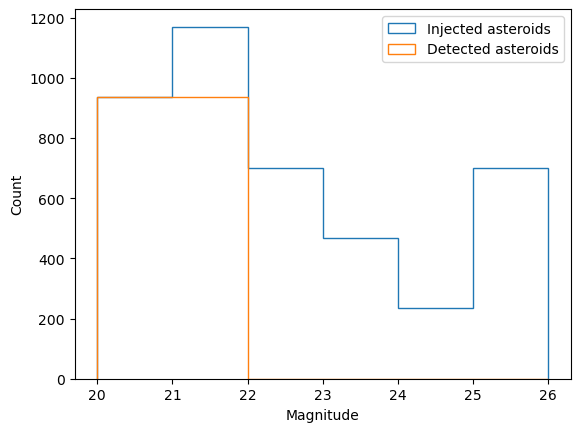

In [129]:
fig, ax = plt.subplots()
ax.hist(original_trails["mag"].values, bins=np.arange(20,27,1), histtype="step", label="Injected asteroids")
ax.hist(matched_trails["mag"].values, bins=np.arange(20,27, 1), histtype="step", label="Detected asteroids")
ax.set_xlabel("Magnitude")
ax.set_ylabel("Count")
ax.legend()